Marcin Damek, M.Cem Eriş, Mehmet Sezer, Recep O. Yıldız
{damek20, erismu, sezer20, yildizr} @itu.edu.tr

 ITU BLG 549E Graph Theory and Algorithms Project

Reference Metadata: 
https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz

*****************************************************************************
 IMPORTANT NOTE:

This Jupyter Notebook File parses the The Amazon Product Co-Purchasing Network Metadata Dataset in [1, 2].  This metadata has 548552 Products, 7781990 Reviews and 15010575 lines of data which is in total 977.5 MB.

Due to its huge size, it takes nearly 30 minutes of parsing this metadata in a regular laptop.

So, please add the metadata in [1] to the same directory with this ipynb file and run the next cell.

The parser will create adjacency matrices in csv format for video and DVDs and, save them tho the saved_adj_matrices directory.


In [13]:
#Necessary libraries to parse data
import time
import pandas as pd
import numpy as np
import networkx as nx
import project_view as pv

In [16]:
# Selected products to process
# Options : 'Book', 'Music', 'Video', 'DVD'
selectedGroup1 = 'Video'
selectedGroup2 = 'DVD'

# If the user wants to process only G1 or G2, the user can select 
# desired group with variables below. 
# True -> Run,     False -> Ignore 
run_G1 = True
run_G2 = True

# File names to store parsed and processed products
metadata_file = "amazon-meta.txt"             # Metadata of Amazon [1]
graph1_df_file = "saved_dataframes/g1Db.csv"  # Database file of parsed G1 products
graph2_df_file = "saved_dataframes/g2Db.csv"  # Database file of parsed G2 products
global_df_file = "saved_dataframes/database.csv"

g1_clean = "saved_dataframes/g1Db_clean.csv"  # Final database of G1 products
g2_clean = "saved_dataframes/g2Db_clean.csv"  # Final database of G2 products

adj1_file = "saved_adj_matrices/adj1_min.csv" # Adjacanecy matrix file of G1
adj2_file = "saved_adj_matrices/adj2_min.csv" # Adjacanecy matrix file of G2

# Only keep the nodes that have higher than given node degree during adjacency matrix calculation
g1_threshold_node_degree = 13  # 5 intended initially
g2_threshold_node_degree = 16  # 8 intended initially


# Parsing products' information from the Amazon's metadata. 
    Each product stored in a dictionary. The dictionary of a product has gthe following keys: Id,ASIN, group, salesrank, totalSimilar, s1, s2, s3, s4, s5, totalReview, avgRate, totalVote
    The code below generates two ".csv" files. One for "selectedGroup1" and one for "selectedGroup2". 

In [7]:
product = {}                    # Dictionary of a product
productList = []                # List of products
similarProduct = {}
similarityLabel = ['totalSimilar', 's1', 's2', 's3', 's4', 's5']
totalReview = 0
reviewCounter = 0
voteCounter = 0

g1IdList = []  # ID of selectedGroup1 products
g1PrList = []  # List of selectedGroup1 products
g2IdList = []  # ID of selectedGroup2 products
g2PrList = []  # List of selectedGroup2 products


# Read all lines of the meta data into content list.
with open(metadata_file, encoding='utf8') as f:
    content = f.readlines()
    
# Remove the beginning and trailing white spaces.
content = [x.strip() for x in content]

# Loop for each row in metadata
for line in content:
    
    parser_colon = line.split(':')
    parser_space = line.split()
    
    # Check if the line is valid for parsing
    if len(parser_colon) > 1 and parser_space[0] != 'Total' and not (
    parser_space[0].startswith('|')):  # startswith is added to prevent category conflicts
        
        # Categroy and title aren't used for processing dataset
        if parser_colon[0] != 'categories' and parser_colon[0] != 'title':
            
            #Get the similar products
            if parser_colon[0] == 'similar':
                similarityLine = parser_colon[1].split(' ')
                similarityLine = list(filter(None, similarityLine))
                
                # add none if there are less then 5 similar items to make processing easier
                while len(similarityLine) != 6:
                    similarityLine.append(None)  
                
                # Get the number of similar products and ASINs' of similar products 
                # asindividual cell
                similarProduct[product['Id']] = similarityLine
                product = {**product, **dict(zip(similarityLabel, similarityLine))}

            # Get the revievers statistics
            elif parser_colon[0] == 'reviews' and parser_colon[1].strip() == 'total':
                product['totalReview'] = parser_colon[3].split(' ')[1]
                product['avgRate'] = parser_colon[4].strip()
                totalReview = int(product['totalReview'])
                
                # If there is no reivew, set totalVote as 0
                if totalReview == 0:
                    product['totalVote'] = 0
                    productList.append(product)
                    product = {}

            # Process each review that product takes
            elif reviewCounter < totalReview:
                if parser_space[1] == "cutomer:":
                    reviewCounter = reviewCounter + 1
                    voteCounter = voteCounter + int(parser_space[6]) # sum all votes in reviews
                    if reviewCounter == totalReview:
                        product['totalVote'] = voteCounter
                        voteCounter = 0
                        totalReview = 0
                        reviewCounter = 0
                        productList.append(product)
                        product = {}
            
            # Get the other information directly, since no further parsing is required
            else:
                product[parser_colon[0]] = parser_colon[1].strip()

                # Append the ID of the product into list where it belongs to
                if parser_colon[0] == "group":
                    currentGroup = product['group']
                    if currentGroup == selectedGroup1:
                        g1IdList.append(product['Id'])
                    elif currentGroup == selectedGroup2:
                        g2IdList.append(product['Id'])

# Generate the G1 database by checking ID list of G1
g1Counter = 0
for pr in productList:
    if pr['Id'] == g1IdList[g1Counter]:
        g1PrList.append(pr)
        g1Counter = g1Counter + 1
        if g1Counter == len(g1IdList):
            break

# Generate the G2 database by checking ID list of G2
g2Counter = 0
for pr in productList:
    if pr['Id'] == g2IdList[g2Counter]:
        g2PrList.append(pr)
        g2Counter = g2Counter + 1
        if g2Counter == len(g2IdList):
            break
            
# Crete Panda dataframe which includes all product in metadata
dataset = pd.DataFrame.from_dict(productList)
with open(global_df_file, 'w', newline='') as myfile:
    dataset.to_csv(global_df_file)

g1Db = pd.DataFrame.from_dict(g1PrList)

num_of_nodes1, col1 = g1Db.shape

# Crete Panda dataframe which includes products belongs to selectedGroup1
g1Db.insert(0, "nodeId", np.full((num_of_nodes1,), range(num_of_nodes1)), True)
with open(graph1_df_file, 'w', newline='') as myfile:
    g1Db.to_csv(graph1_df_file)

g2Db = pd.DataFrame.from_dict(g2PrList)

num_of_nodes2, col2 = g2Db.shape

# Crete Panda dataframe which includes products belongs to selectedGroup2
g2Db.insert(0, "nodeId", np.full((num_of_nodes2,), range(num_of_nodes2)), True)
with open(graph2_df_file, 'w', newline='') as myfile:
    g2Db.to_csv(graph2_df_file)


There are some products in similar products list. They are not belongs to selected group. They need to be removed from the database. Because, they leads to conflicts in graph. 
The code below checks each similar product. To do that, similar products of each product in database has to be visited. To reduce the computation cost, total votes of the similar products added to the database. Also, ASIN of similar products is changed with the Id of that products.

In [10]:
start_time = time.time()
print("Started...")

# Read parsed information
g1 = pd.read_csv(graph1_df_file)
g2 = pd.read_csv(graph2_df_file)

# Drop additional columns which is added by Pandas
g1 = g1.drop('Unnamed: 0', axis=1)
g2 = g2.drop('Unnamed: 0', axis=1)

if run_G1:
    print("Running G1")
    # Add new column to store how many times a product appear in similarity relationship
    g1['visited'] = 0   
    for index, row in g1.iterrows():
        removeS = []
        # Append columns that holds votes of similar products
        for j in range(5):
            vote_index = "v" + str(j + 1)
            g1.at[index, vote_index] = 0
        # Even if there may be less than 5 similar products, it is undetermined their indices. 
        for i in range(5):
            # similarity_indices: s1, s2, s3, s4 ,s5
            similarity_index = "s" + str(i + 1)
            similar_product_asin = row[similarity_index]
            # if the similar cell is null
            if isinstance(row[similarity_index], float):
                continue
            # Get the full information of similar product
            similar_product_row = g1[g1['ASIN'].str.contains(similar_product_asin)]
            # If the similar product doesn't exist in database
            if similar_product_row['ASIN'].empty:
                removeS.append(similarity_index)
            else:
                vote_index = "v" + str(i + 1)
                # Get the index of similar product
                visitedIndex = list(similar_product_row['visited'].to_dict())[0]
                # Increase number of visiting the similat product by one
                g1.at[visitedIndex, 'visited'] = g1.at[visitedIndex, 'visited'] + 1
                # Increase number of visiting the product by one
                g1.at[index, 'visited'] = g1.at[index, 'visited'] + 1
                # Replace ASIN of similar product with Id of product
                g1.at[index, similarity_index] = int(similar_product_row['Id'])
                # Append total vote of the similar product to database
                g1.at[index, vote_index] = int(similar_product_row['totalVote'])
        # Calculate the number of silimar product after removing products which belongs to different group
        g1.at[index, 'totalSimilar'] = row['totalSimilar'] - len(removeS)
        # Remove products which belongs to different group
        for s in (removeS):
            g1.at[index, s] = None
    # Remove product if it doesn't have any similar product and it isn't visited by other products
    for index, row in g1.iterrows():
        if row['totalSimilar'] == 0 and g1.at[index, 'visited'] == 0:
            g1.drop(index, inplace=True)
    # After remoing products and appending information, save the database to g1_clean file
    with open(g1_clean, 'w', newline='') as myfile:
        g1.to_csv(g1_clean)

g1_time = time.time()
print("G1 is finished in --- %s seconds ---" % (g1_time - start_time))

if run_G2:
    print("Running G2")
    # Add new column to store how many times a product appear in similarity relationship
    g2['visited'] = 0
    for index, row in g2.iterrows():
        removeS = []
        # Append columns that holds votes of similar products
        for j in range(5):
            vote_index = "v" + str(j + 1)
            g2.at[index, vote_index] = None
        # Even if there may be less than 5 similar products, it is undetermined their indices. 
        for i in range(5):
            # similarity_indices: s1, s2, s3, s4 ,s5
            similarity_index = "s" + str(i + 1)
            similar_product_asin = row[similarity_index]
            # if the similar cell is null
            if isinstance(row[similarity_index], float):
                continue
            # Get the full information of similar product
            similar_product_row = g2[g2['ASIN'].str.contains(similar_product_asin)]
            # If the similar product doesn't exist in database
            if similar_product_row['ASIN'].empty:
                removeS.append(similarity_index)
            else:
                vote_index = "v" + str(i + 1)
                # Get the index of similar product
                visitedIndex = list(similar_product_row['visited'].to_dict())[0]
                # Increase number of visiting the similat product by one
                g2.at[visitedIndex, 'visited'] = g2.at[visitedIndex, 'visited'] + 1
                # Increase number of visiting the product by one
                g2.at[index, 'visited'] = g2.at[index, 'visited'] + 1
                # Replace ASIN of similar product with Id of product
                g2.at[index, similarity_index] = int(similar_product_row['Id'])
                # Append total vote of the similar product to database
                g2.at[index, vote_index] = int(similar_product_row['totalVote'])
        # Calculate the number of silimar product after removing products which belongs to different group
        g2.at[index, 'totalSimilar'] = row['totalSimilar'] - len(removeS)
        # Remove products which belongs to different group
        for s in (removeS):
            g2.at[index, s] = None
    # Remove product if it doesn't have any similar product and it isn't visited by other products
    for index, row in g2.iterrows():
        if row['totalSimilar'] == 0 and g2.at[index, 'visited'] == 0:
            g2.drop(index, inplace=True)
    # After remoing products and appending information, save the database to g1_clean file
    with open(g2_clean, 'w', newline='') as myfile:
        g2.to_csv(g2_clean)

g2_time = time.time()
print("G2 is finished --- %s seconds ---" % (g2_time - g1_time))

print("All finished in %s seconds." % (time.time() - start_time))

Started...
Running G1
G1 is finished in --- 1062.008787870407 seconds ---
Running G2
G2 is finished --- 787.9775199890137 seconds ---
All finished in 1849.9865753650665 seconds.


    To generate adjacency matrix from the parsen products' information, the code below is used. Before gneration adjacency matrix, a treshold applied to data. Treshold removes the prodeuct if it has lower node degree than defined "g1_threshold_node_degree" and "g2_threshold_node_degree" values. With the remaining p

Started...
Running G1
Number of nodes : 453 number of edges : 632


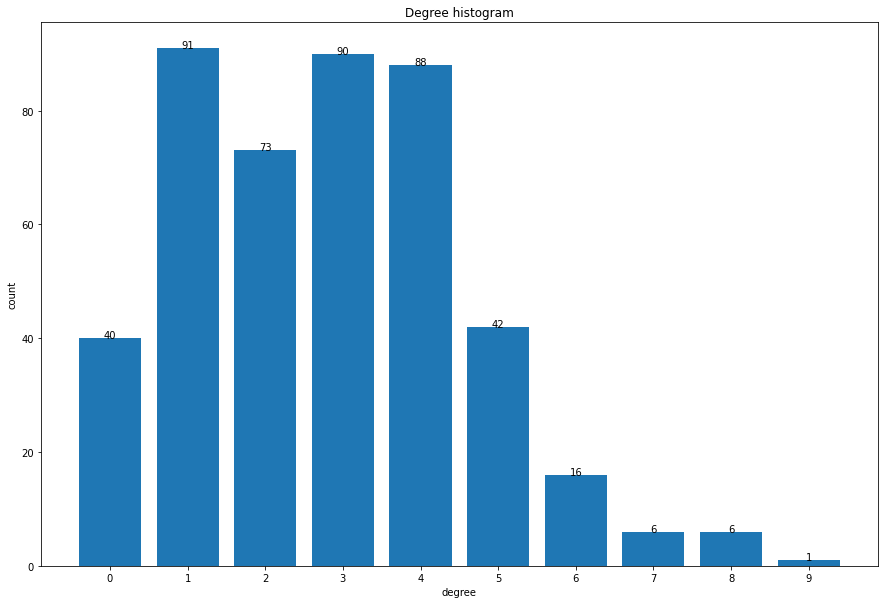

G1 is finished in --- 39.520790338516235 seconds ---
Running G2
Number of nodes : 658 number of edges : 818


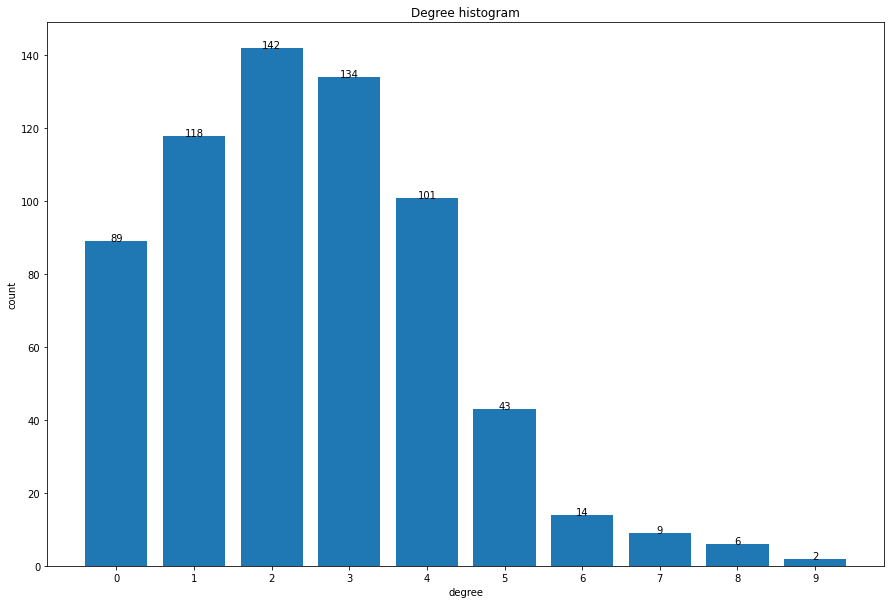

G2 is finished --- 0.5873594284057617 seconds ---
All finished in 40.10846495628357 seconds.


In [17]:
start_time = time.time()
print("Started...")

# Read G1 and G2 databases
g1 = pd.read_csv(g1_clean)
g2 = pd.read_csv(g2_clean)

# Remove the nodes with lower node degree than g1_threshold_node_degree
for index, row in g1.iterrows():
    if row['totalSimilar'] == 0 or g1.at[index, 'visited'] < g1_threshold_node_degree:
        g1.drop(index, inplace=True)

# Remove the nodes with lower node degree than g2_threshold_node_degree
for index, row in g2.iterrows():
    if row['totalSimilar'] == 0 or g2.at[index, 'visited'] < g2_threshold_node_degree:
        g2.drop(index, inplace=True)

n1, col1 = g1.shape
n2, col2 = g2.shape

# Init empty arrays for adjacency matrixes
adj_1 = np.zeros((n1, n1), dtype=int)
adj_2 = np.zeros((n2, n2), dtype=int)

if run_G1:
    print("Running G1")
    # Create a dictionary to associcate Id values of the product with increasing index
    idDict = {}
    j = 0
    for i in g1['Id']:
        idDict[i] = j
        j = j + 1
        
    for index, row in g1.iterrows():
        for i in range(5):
            # similarity_indices: s1, s2, s3, s4 ,s5
            similarity_index = "s" + str(i + 1)
            vote_index = "v" + str(i + 1)
            # if the similar cell is null
            if np.isnan(row[similarity_index]):
                continue
            # Get the index of product and similar from idDict
            x = idDict.get(row['Id'])
            y = idDict.get(row[similarity_index])
            # Continue if the similar product is removed because of tresholding
            if y is None:
                continue
            if adj_1[x][y] == 0:
                # sum both products' totalVote values
                weight = row['totalVote'] + row[vote_index]
                # assign the weight to the corresponding spot
                adj_1[x][y] = weight

    # Generate numpy matrix from adjacency matrix of selected group 1 and save it
    G1 = nx.from_numpy_matrix(adj_1)
    num_of_nodes, num_of_edges = pv.get_nodes_and_edges_number(G1)
    print("Number of nodes :", num_of_nodes, "number of edges :", num_of_edges)
    pd.DataFrame(adj_1).to_csv(adj1_file)
    pv.plot_degree_dist(G1)

g1_time = time.time()
print("G1 is finished in --- %s seconds ---" % (g1_time - start_time))

if run_G2:
    print("Running G2")
    # Create a dictionary to associcate Id values of the product with increasing index
    idDict = {}
    j = 0
    for i in g2['Id']:
        idDict[i] = j
        j = j + 1
    for index, row in g2.iterrows():
        for i in range(5):
            # similarity_indices: s1, s2, s3, s4 ,s5
            similarity_index = "s" + str(i + 1)
            vote_index = "v" + str(i + 1)
            # if the similar cell is null
            if np.isnan(row[similarity_index]):
                continue
            # Get the index of product and similar from idDict
            x = idDict.get(row['Id'])
            y = idDict.get(row[similarity_index])
            # Continue if the similar product is removed because of tresholding
            if y is None:
                continue
            if adj_2[x][y] == 0:
                # sum both products' totalVote values
                weight = row['totalVote'] + row[vote_index]
                # assign the weight to the corresponding spot
                adj_2[x][y] = weight
                # print(weight)

    # Generate numpy matrix from adjacency matrix of selected group 2 and save it
    G2 = nx.from_numpy_matrix(adj_2)
    num_of_nodes, num_of_edges = pv.get_nodes_and_edges_number(G2)
    print("Number of nodes :", num_of_nodes, "number of edges :", num_of_edges)
    pd.DataFrame(adj_2).to_csv(adj2_file)
    pv.plot_degree_dist(G2)

g2_time = time.time()
print("G2 is finished --- %s seconds ---" % (g2_time - g1_time))

print("All finished in %s seconds." % (time.time() - start_time))

## References

[1] “Amazon Product Metadata and Reviews from Summer 2006.” [Online]. Available: https://snap.stanford.edu/data/bigdata/amazon/amazon-meta.txt.gz. [Accessed: 31-Jan-2021].<br>
[2] “Amazon Product Co-purchasing Network Metadata.” [Online]. Available: https://snap.stanford.edu/data/amazon-meta.html. [Accessed: 31-Jan-2021].<br>